In [20]:
import pathlib
import torch
import torchaudio
import matplotlib.pyplot as plt

In [21]:
# 最長秒數
fs = 20000
n_max = 10 * 60 * fs # 10 minutes

In [126]:
# read references
in1_fp = pathlib.Path("../data/APLAWDW_EGG_YAGAV_GCI/aw02c1.egg.txt")
in2_fp = pathlib.Path("../data/APLAWDW_WAV_ZFF/aw02c1.wav.txt")
in3_fp = pathlib.Path("../data/APLAWDW_WAV_BPDP5_5/aw02c1.wav.txt")

In [127]:
fs / 120

166.66666666666666

In [128]:
p0 = torch.tensor([int(c) for c in in1_fp.read_text().split()])
p1 = torch.tensor([int(c) for c in in2_fp.read_text().split()])
p2 = torch.tensor([int(c) for c in in3_fp.read_text().split()])

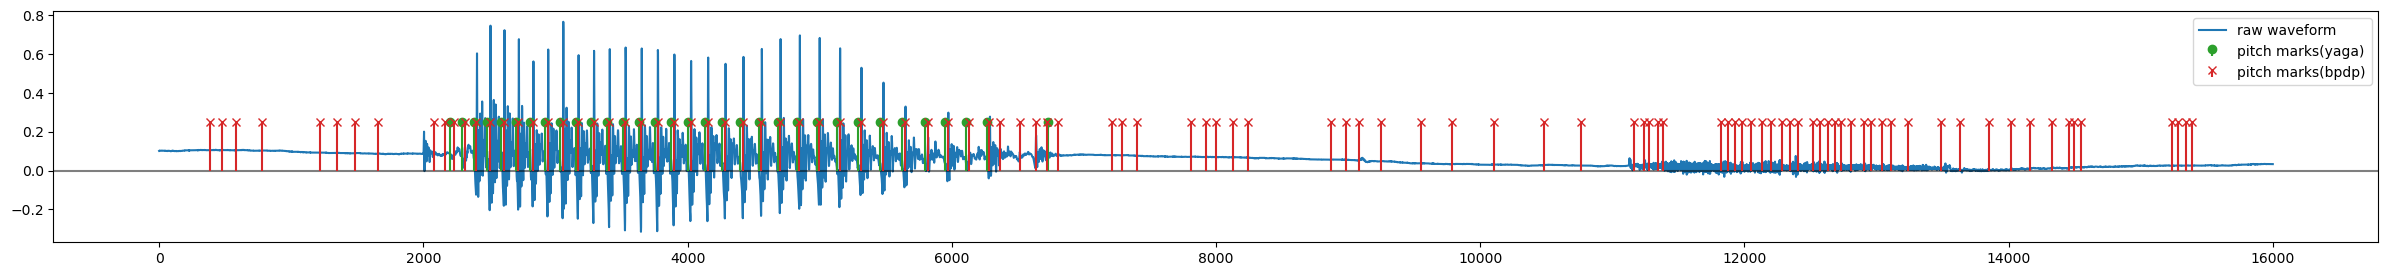

In [129]:
# 因為 SIGMA 會有 FALSE ALARM 的問題，這邊使用 YAGA 抽 EGG 的 GCI

# ad00a0
in_fp = pathlib.Path("../data/APLAWDW/w/02/c/aw02c1.wav")

wav, sr = torchaudio.load(str(in_fp))

fig, ax = plt.subplots(1,1, figsize=(30,3))
t = 0
l = wav.shape[-1]

_time = torch.arange(t, t+l)


#ax.plot(wav[0, t:t+10000])
ax.plot(_time, wav[0, t:t+l], label="raw waveform")
#ax.plot(_time, y1[t:t+10000]/20, label="lowpass filtered waveform" )
ax.axhline(0, color='black', alpha=0.5)

# filter the p0
_p = torch.tensor([x for x in p0 if t < x < t + l])
_y = torch.ones_like(_p)*0.25
ax.stem(_p.numpy(), _y.numpy(), 'C2-', basefmt=" ", label="pitch marks(yaga)")

# filter the p2
_p = torch.tensor([x for x in p2 if t < x < t + l])
_y = torch.ones_like(_p)*0.25
ax.stem(_p.numpy(), _y.numpy(), 'C3-', markerfmt="x", basefmt=" ", label="pitch marks(bpdp)")

ax.legend()
# fig.savefig("ZFF_as03i1.pdf", bbox_inches = 'tight',  pad_inches = 0.1)

In [112]:
len(intervals)

72

In [13]:
# 計算 id rate
cnt_id = 0
cnt_miss = 0
cnt_fa = 0

sum_bias = 0 # samples
sum_squares = 0

for interval in intervals:
    loc = torch.searchsorted(p2, interval)
    num_items = loc[2] - loc[0]
    if num_items == 0:
        cnt_miss += 1
    elif num_items == 1:
        cnt_id += 1
        err = int(p2[loc[1]] - interval[1])
        sum_bias += err
        sum_squares += err**2
    elif num_items > 1:
        cnt_id += 1
        cnt_fa += num_items - 1
        err = int(p2[loc[1]] - interval[1])
        sum_bias += err
        sum_squares += err**2

In [ ]:
# 新的 evaluate code

In [50]:
def evaluate(cmp_dir):
    src_dir = pathlib.Path("../data/APLAWDW_EGG_YAGAV_GCI/")
    cmp_dir = pathlib.Path(cmp_dir)
    sr = 20000

    cnt = 0
    cnt_est = 0
    cnt_id = 0
    cnt_miss = 0
    cnt_fa = 0
    cnt_fat = 0
    cnt_outside = 0
    sum_err = 0
    sum_ser = 0
    
    for p0_path in sorted(src_dir.glob("*.txt")):
        print(p0_path, end="\r")
        p1_path = cmp_dir / p0_path.name.replace(".egg.txt", ".wav.txt")
        
        p0 = torch.tensor([int(c) for c in p0_path.read_text().split()])
        p1 = torch.tensor([int(c) for c in p1_path.read_text().split()])

        intervals = []
        

        for i in range(len(p0)):
            if i == 0:
                left = p0[0] - 30
            else:
                left = (p0[i-1] + p0[i]) / 2
                
            if i == len(p0) - 1:
                right = p0[i] + 30
            else:
                right = (p0[i] + p0[i+1]) / 2
            intervals.append((left, p0[i], right))
                
        cnt += len(intervals)
        for (left, center, right) in intervals:
            mask = ((p1 >= left) & (p1 < right))
            match = mask.sum()
            if match == 0:
                cnt_miss += 1
            elif match == 1:
                cnt_id += 1
                err = p1[mask].item() - center
                sum_err += err
                sum_ser += err ** 2
            else:
                cnt_fa += 1
                cnt_fat += match - 1 
        cnt_est += int( p1.shape[0] )
    print("")
    print(f"IDR: {cnt_id / cnt}")
    print(f"MR: {cnt_miss / cnt}")
    print(f"FAR: {cnt_fa / cnt}")
    print(f"FAT: {cnt_fat / cnt}")
    print(f"Bias: {sum_err/cnt_id/sr*1000}")
    print(f"IDA: {(sum_ser/cnt_id - (sum_err/cnt_id)**2)**0.5 / sr * 1000}")

In [70]:
evaluate("../data/APLAWDW_WAV_BPDP5/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.903766722780358
MR: 0.061398501136630756
FAR: 0.034834776083011276
FAT: 0.17020991444587708
Bias: 1.6826155185699463
IDA: 1.0924574136734009


In [71]:
evaluate("../data/APLAWDW_WAV_BP_2/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.43343665455331215
MR: 0.04111727080136483
FAR: 0.525446074645323
FAT: 0.9539113640785217
Bias: 1.5390428304672241
IDA: 1.3113501071929932


In [69]:
# p = bpdp(wav[0].view(-1), sr, wl_0=0.05, wl_1=0.035, f_lo=50.0, f_hi=550.0, beam_size=5, filt="bp1")
evaluate("../data/APLAWDW_WAV_BPDP5_2/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.9061772267961613
MR: 0.05508096577843512
FAR: 0.03874180742540359
FAT: 0.21178855001926422
Bias: 1.5218751430511475
IDA: 1.0486347675323486


In [73]:
evaluate("../data/APLAWDW_WAV_BP_3/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.3201342056505952
MR: 0.03164461783072159
FAR: 0.6482211765186833
FAT: 1.5022082328796387
Bias: 1.5209240913391113
IDA: 1.3426307439804077


In [72]:
# p = bpdp(wav[0].view(-1), sr, wl_0=0.05, wl_1=0.002, f_lo=50.0, f_hi=400.0, beam_size=5, filt="bp1")
evaluate("../data/APLAWDW_WAV_BPDP5_3/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.9110376555475903
MR: 0.0503767598796354
FAR: 0.0385855845727743
FAT: 0.22938625514507294
Bias: 1.4352762699127197
IDA: 0.9724043607711792


In [130]:
1 / 400 

0.0025

In [74]:
# p = bpdp(wav[0].view(-1), sr, wl_0=0.05, wl_1=0.0015, f_lo=50.0, f_hi=400.0, beam_size=5, filt="bp1")
evaluate("../data/APLAWDW_WAV_BPDP5_4/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.9107354300289523
MR: 0.04708585978779972
FAR: 0.042178710183247946
FAT: 0.26512330770492554
Bias: 1.4146342277526855
IDA: 0.9675200581550598


In [76]:
# p = bpdp(wav[0].view(-1), sr, wl_0=0.05, wl_1=0.0015, f_lo=50.0, f_hi=550.0, beam_size=5, filt="bp1")
# new penality
evaluate("../data/APLAWDW_WAV_BPDP5_5/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.9086461318783681
MR: 0.054549516074163515
FAR: 0.03680435204746839
FAT: 0.23583517968654633
Bias: 1.4278843402862549
IDA: 1.0035556554794312


In [51]:
evaluate("../data/APLAWDW_WAV_YAGA_GCI/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.9337571304052013
MR: 0.027017793344906477
FAR: 0.03922507624989232
FAT: 0.35760870575904846
Bias: 0.9787982702255249
IDA: 0.6878879070281982


In [68]:
evaluate("../data/APLAWDW_WAV_ZFFLP/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.8992187397341875
MR: 0.07077771240102844
FAR: 0.03000354786478401
FAT: 0.0913567915558815
Bias: 2.0365986824035645
IDA: 1.4695932865142822


In [75]:
evaluate("../data/APLAWDW_WAV_ZFF/")

../data/APLAWDW_EGG_YAGAV_GCI/ax44j9.egg.txt
IDR: 0.29911420182532533
MR: 0.695441358759211
FAR: 0.0054444394154637265
FAT: 0.009336870163679123
Bias: 1.3819317817687988
IDA: 3.840937852859497


In [52]:
# 計算所有的檔案
tgt_dp = pathlib.Path("../data/APLAWDW_EGG_YAGAV_GCI/")
src_dp = pathlib.Path("../data/APLAWDW_WAV_BPDP5/")

cnt = 0

cnt_id = 0
cnt_miss = 0
cnt_fa = 0
cnt_fat = 0

sum_bias = 0 # samples
sum_squares = 0

for txt_fp in src_dp.glob("*.txt"):
    base = txt_fp.stem.removesuffix(".wav")
    in0_fp = tgt_dp / f"{base}.egg.txt"
    in1_fp = txt_fp

    if not in0_fp.exists():
        continue
    
    p0 = torch.tensor([int(c) for c in in0_fp.read_text().split()])
    p1 = torch.tensor([int(c) for c in in1_fp.read_text().split()])

    # 取得和下一個點之間的差值
    d = torch.diff(p0)
    lbounds = p0[1:-1] - (d[:-1] / 2).clamp(max=250)
    rbounds = p0[1:-1] + (d[1:]  / 2).clamp(max=250)
    intervals = torch.stack((lbounds, p0[1:-1], rbounds), dim=1)

    for interval in intervals:
        cnt += 1
        loc = torch.searchsorted(p1, interval)
        num_items = loc[2] - loc[0]
        if num_items == 0:
            cnt_miss += 1
        elif num_items == 1:
            if loc[1] >= len(p1):
                loc[1] = len(p1) - 1
            cnt_id += 1
            err = int(p1[loc[1]] - interval[1])
            sum_bias += err
            sum_squares += err**2
        elif num_items > 1:
            cnt_fa += 1 #num_items - 1
            cnt_fat += num_items - 1
            
print(f"IDR: {cnt_id / cnt}")
print(f"FAR: {cnt_fa / cnt}")
print(f"FATR: {cnt_fat / cnt}")
print(f"Bias: {sum_bias/cnt_id/20000*1000}")
print(f"IDA: {(sum_squares/cnt_id - (sum_bias/cnt_id)**2)**0.5 /20000*1000}")


IDR: 0.8989883296654565
FAR: 0.021865473638800356
FATR: 0.02622016705572605
Bias: 2.4977639950603696
IDA: 2.651037581692383


In [282]:
cnt_id, cnt_miss, cnt_fa, sum_bias/cnt_id, sum_squares/cnt_id, 

(637486, 25477, tensor(39156), 36.29668573113762, 1894.6566465773367)

In [285]:
637486/(637486 + 25477)

0.9615710077334633

In [301]:
39156 / (637486 + 25477)

0.05906211960546818

In [300]:
36.2967 / 20000 * 1000

1.8148350000000002

In [37]:
# 計算所有的檔案
tgt_dp = pathlib.Path("../data/APLAWDW_EGG_YAGAV_GCI/")
src_dp = pathlib.Path("../data/APLAWDW_WAV_YAGA_GCI/")

cnt = 0
cnt_id = 0
cnt_miss = 0
cnt_fa = 0
cnt_fat = 0

sum_bias = 0 # samples
sum_squares = 0

for txt_fp in src_dp.glob("*.txt"):
    base = txt_fp.stem.removesuffix(".wav")
    in0_fp = tgt_dp / f"{base}.egg.txt"
    in1_fp = txt_fp

    if not in0_fp.exists():
        continue
    
    p0 = torch.tensor([int(c) for c in in0_fp.read_text().split()])
    p1 = torch.tensor([int(c) for c in in1_fp.read_text().split()])

    # 取得和下一個點之間的差值
    d = torch.diff(p0)
    lbounds = p0[1:-1] - (d[:-1] / 2).clamp(max=250)
    rbounds = p0[1:-1] + (d[1:]  / 2).clamp(max=250)
    intervals = torch.stack((lbounds, p0[1:-1], rbounds), dim=1)

    for interval in intervals:
        cnt += 1
        loc = torch.searchsorted(p1, interval)
        num_items = loc[2] - loc[0]
        if num_items == 0:
            cnt_miss += 1
        elif num_items == 1:
            if loc[1] >= len(p1):
                loc[1] = len(p1) - 1
            cnt_id += 1
            err = int(p1[loc[1]] - interval[1])
            sum_bias += err
            sum_squares += err**2
        elif num_items > 1:
            cnt_fa += 1 #num_items - 1
            cnt_fat += num_items - 1
            
print(f"IDR: {cnt_id / cnt}")
print(f"FAR: {cnt_fa / cnt}")
print(f"FATR: {cnt_fat / cnt}")
print(f"Bias: {sum_bias/cnt_id/20000*1000}")
print(f"IDA: {(sum_squares/cnt_id - (sum_bias/cnt_id)**2)**0.5 /20000*1000}")


IDR: 0.9423165395353889
FAR: 0.03605329407523497
FATR: 0.07147608697414398
Bias: 1.275354038042582
IDA: 1.33983301339783


In [284]:
cnt_id, cnt_miss, cnt_fa, sum_bias/cnt_id, sum_squares/cnt_id, 

(648623, 14340, tensor(47386), 26.189239357839607, 1527.218795818218)

In [286]:
648623 / (648623 + 14340)

0.9783698336106238

In [302]:
47386 / (648623 + 14340)

0.07147608539239747

In [304]:
26.189239357839607 / 20000 * 1000

1.3094619678919803

In [33]:
# 計算所有的檔案
tgt_dp = pathlib.Path("../data/APLAWDW_EGG_YAGAV_GCI/")
src_dp = pathlib.Path("../data/APLAWDW_WAV_ZFF/")

cnt = 0
cnt_id = 0
cnt_miss = 0
cnt_fa = 0
cnt_fat = 0

sum_bias = 0 # samples
sum_squares = 0

for txt_fp in src_dp.glob("*.txt"):
    base = txt_fp.stem.removesuffix(".wav")
    in0_fp = tgt_dp / f"{base}.egg.txt"
    in1_fp = txt_fp

    if not in0_fp.exists():
        continue
    
    p0 = torch.tensor([int(c) for c in in0_fp.read_text().split()])
    p1 = torch.tensor([int(c) for c in in1_fp.read_text().split()])

    # 取得和下一個點之間的差值
    d = torch.diff(p0)
    lbounds = p0[1:-1] - (d[:-1] / 2).clamp(max=250)
    rbounds = p0[1:-1] + (d[1:]  / 2).clamp(max=250)
    intervals = torch.stack((lbounds, p0[1:-1], rbounds), dim=1)

    for interval in intervals:
        cnt += 1
        loc = torch.searchsorted(p1, interval)
        num_items = loc[2] - loc[0]
        
        if num_items == 0 or loc[0] >= len(p1) - 1:
            cnt_miss += 1
        elif num_items == 1:
            if loc[1] >= len(p1):
                loc[1] = len(p1) - 1
            cnt_id += 1
            err = int(p1[loc[1]] - interval[1])
            sum_bias += err
            sum_squares += err**2
        elif num_items > 1:
            cnt_fa += 1 #num_items - 1
            cnt_fat += num_items - 1
            
print(f"IDR: {cnt_id / cnt}")
print(f"FAR: {cnt_fa / cnt}")
print(f"FATR: {cnt_fat / cnt}")
print(f"Bias: {sum_bias/cnt_id/20000*1000}")
print(f"IDA: {(sum_squares/cnt_id - (sum_bias/cnt_id)**2)**0.5 /20000*1000}")


IDR: 0.2962638940634696
FAR: 0.004730279065347539
FATR: 0.005228044465184212
Bias: 2.394815489888601
IDA: 11.973695237389773


In [293]:
cnt_id, cnt_miss, cnt_fa, sum_bias/cnt_id, sum_squares/cnt_id

(199548, 463415, tensor(3466), 48.0884348627899, 60081.68012207589)

In [294]:
199548/(199548 + 463415)

0.30099417312881716

In [305]:
3466/(199548 + 463415)

0.005228044400667911

In [306]:
48.0884 / 20000 * 1000

2.40442

In [34]:
# 計算所有的檔案
tgt_dp = pathlib.Path("../data/APLAWDW_EGG_YAGAV_GCI/")
src_dp = pathlib.Path("../data/APLAWDW_WAV_ZFFLP/")

cnt = 0
cnt_id = 0
cnt_miss = 0
cnt_fa = 0
cnt_fat = 0

sum_bias = 0 # samples
sum_squares = 0

for txt_fp in src_dp.glob("*.txt"):
    base = txt_fp.stem.removesuffix(".wav")
    in0_fp = tgt_dp / f"{base}.egg.txt"
    in1_fp = txt_fp

    if not in0_fp.exists():
        continue
    
    p0 = torch.tensor([int(c) for c in in0_fp.read_text().split()])
    p1 = torch.tensor([int(c) for c in in1_fp.read_text().split()])

    # 取得和下一個點之間的差值
    d = torch.diff(p0)
    lbounds = p0[1:-1] - (d[:-1] / 2).clamp(max=250)
    rbounds = p0[1:-1] + (d[1:]  / 2).clamp(max=250)
    intervals = torch.stack((lbounds, p0[1:-1], rbounds), dim=1)

    for interval in intervals:
        cnt += 1
        loc = torch.searchsorted(p1, interval)
        num_items = loc[2] - loc[0]
        
        if num_items == 0 or loc[0] >= len(p1) - 1:
            cnt_miss += 1
        elif num_items == 1:
            if loc[1] >= len(p1):
                loc[1] = len(p1) - 1
            cnt_id += 1
            err = int(p1[loc[1]] - interval[1])
            sum_bias += err
            sum_squares += err**2
        elif num_items > 1:
            if loc[1] >= len(p1):
                loc[1] = len(p1) - 1
            cnt_fa += 1 #num_items - 1
            cnt_fat += num_items - 1
            
print(f"IDR: {cnt_id / cnt}")
print(f"FAR: {cnt_fa / cnt}")
print(f"FATR: {cnt_fat / cnt}")
print(f"Bias: {sum_bias/cnt_id/20000*1000}")
print(f"IDA: {(sum_squares/cnt_id - (sum_bias/cnt_id)**2)**0.5 /20000*1000}")


IDR: 0.9189532447512154
FAR: 0.021346590986223966
FATR: 0.026185473427176476
Bias: 2.385286229219739
IDA: 2.185323970229316


In [35]:
# 計算所有的檔案
tgt_dp = pathlib.Path("../data/APLAWDW_EGG_YAGAV_GCI/")
src_dp = pathlib.Path("../data/APLAWDW_WAV_BP/")

cnt = 0
cnt_id = 0
cnt_miss = 0
cnt_fa = 0
cnt_fat = 0

sum_bias = 0 # samples
sum_squares = 0

for txt_fp in src_dp.glob("*.txt"):
    base = txt_fp.stem.removesuffix(".wav")
    in0_fp = tgt_dp / f"{base}.egg.txt"
    in1_fp = txt_fp

    if not in0_fp.exists():
        continue
    
    p0 = torch.tensor([int(c) for c in in0_fp.read_text().split()])
    p1 = torch.tensor([int(c) for c in in1_fp.read_text().split()])

    # 取得和下一個點之間的差值
    d = torch.diff(p0)
    lbounds = p0[1:-1] - (d[:-1] / 2).clamp(max=250)
    rbounds = p0[1:-1] + (d[1:]  / 2).clamp(max=250)
    intervals = torch.stack((lbounds, p0[1:-1], rbounds), dim=1)

    for interval in intervals:
        cnt += 1
        loc = torch.searchsorted(p1, interval)
        num_items = loc[2] - loc[0]
        
        if num_items == 0 or loc[0] >= len(p1) - 1:
            cnt_miss += 1
        elif num_items == 1:
            if loc[1] >= len(p1):
                loc[1] = len(p1) - 1
            cnt_id += 1
            err = int(p1[loc[1]] - interval[1])
            sum_bias += err
            sum_squares += err**2
        elif num_items > 1:
            if loc[1] >= len(p1):
                loc[1] = len(p1) - 1
            cnt_fa += 1 #num_items - 1
            cnt_fat += num_items - 1
            
print(f"IDR: {cnt_id / cnt}")
print(f"FAR: {cnt_fa / cnt}")
print(f"FATR: {cnt_fat / cnt}")
print(f"Bias: {sum_bias/cnt_id/20000*1000}")
print(f"IDA: {(sum_squares/cnt_id - (sum_bias/cnt_id)**2)**0.5 /20000*1000}")


IDR: 0.39138383288358475
FAR: 0.5836796321966686
FATR: 0.817867636680603
Bias: 2.074941323374686
IDA: 1.0423699212416533
